In [216]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict
import warnings
from sklearn.metrics import accuracy_score, auc, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, average_precision_score, roc_auc_score,  recall_score,  precision_recall_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from hyperopt import hp, tpe, STATUS_OK, fmin, Trial

from optbinning import OptimalBinning
from optbinning import Scorecard, BinningProcess
import xgboost as xgb

In [245]:
df_train = pd.read_csv('/Users/mengjiatan/Desktop/credit/cs-training.csv')

In [246]:
#drop firt col & change column to lower case 
df_train = df_train.drop('Unnamed: 0', axis = 1)


# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(df_train.columns)):
    cleancolumn.append(df_train.columns[i].lower())
df_train.columns = cleancolumn

df_train

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60-89dayspastduenotworse,numberofdependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


# Outlier detection

In [305]:
print('revolvingutilizationofunsecuredlines\n', df_train['revolvingutilizationofunsecuredlines'].describe())
print()
print('age\n', df_train['age'].describe())
print()
print('numberoftime30-59dayspastduenotworse\n', df_train['numberoftime30-59dayspastduenotworse'].describe())
print()
print('debtratio\n', df_train['debtratio'].describe())
print()
print('monthlyincome\n', df_train['monthlyincome'].describe())
print()
print('numberofopencreditlinesandloans\n', df_train['numberofopencreditlinesandloans'].describe())
print()
print('numberoftimes90dayslate\n', df_train['numberoftimes90dayslate'].describe())
print()
print('numberrealestateloansorlines\n', df_train['numberrealestateloansorlines'].describe())
print()
print('numberoftime60-89dayspastduenotworse\n',df_train['numberoftime60-89dayspastduenotworse'].describe())
print()
print('numberofdependents\n',df_train['numberofdependents'].describe())

revolvingutilizationofunsecuredlines
 count    62418.000000
mean         0.303583
std          0.340016
min          0.000000
25%          0.030332
50%          0.142441
75%          0.514353
max          1.998676
Name: revolvingutilizationofunsecuredlines, dtype: float64

age
 count    62418.000000
mean        51.372969
std         13.939186
min         21.000000
25%         41.000000
50%         50.000000
75%         61.000000
max        102.000000
Name: age, dtype: float64

numberoftime30-59dayspastduenotworse
 count    62418.000000
mean         0.154443
std          0.428101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: numberoftime30-59dayspastduenotworse, dtype: float64

debtratio
 count    62418.000000
mean         0.267721
std          0.199027
min          0.000000
25%          0.112546
50%          0.243861
75%          0.385315
max          1.000000
Name: debtratio, dtype: float64

monthlyincome
 count    

In [239]:
print('revolvingutilizationofunsecuredlines over 2:',(df_train['revolvingutilizationofunsecuredlines'] > 2).sum())#额度用了多少
print('age below 21: ', (df_train['age']<21).sum())#未成年
print('numberoftime30-59dayspastduenotworse over 2:',(df_train['numberoftime30-59dayspastduenotworse']>2).sum())
print('debtratio over 1:',(df_train['debtratio']>1).sum())#debt/income
print('monthly income lower 3125:',(df_train['monthlyincome']<3.125000e+03).sum())
print('numberofopencreditlinesandloans over 11',(df_train['numberofopencreditlinesandloans']>11).sum())#有多少张信用卡
print('numberoftimes90dayslate over 1:',(df_train['numberoftimes90dayslate']>1).sum())
print('numberrealestateloansorlines over 3:',(df_train['numberrealestateloansorlines']>3).sum())#有多少笔账欠着
print('numberoftime60-89dayspastduenotworse over 1:',(df_train['numberoftime60-89dayspastduenotworse']>1).sum())
print('numberofdependents over 4:',(df_train['numberofdependents']>4).sum())#家人越多这个数字越大

revolvingutilizationofunsecuredlines over 2: 371
age below 21:  1
numberoftime30-59dayspastduenotworse over 2: 3351
debtratio over 1: 35137
monthly income lower 3125: 26311
numberofopencreditlinesandloans over 11 34689
numberoftimes90dayslate over 1: 3095
numberrealestateloansorlines over 3: 3652
numberoftime60-89dayspastduenotworse over 1: 1873
numberofdependents over 4: 991


In [247]:
df_train = df_train[(df_train['revolvingutilizationofunsecuredlines'] <= 2) & 
      (df_train['age'] >= 21) & 
      (df_train['numberoftime30-59dayspastduenotworse'] <= 2) & 
      (df_train['debtratio'] <= 1) & 
      (df_train['monthlyincome'] >= 3.125000e+03) & 
      (df_train['numberofopencreditlinesandloans'] <= 11) & 
      (df_train['numberoftimes90dayslate'] <= 1) & 
      (df_train['numberrealestateloansorlines'] <= 3) & 
      (df_train['numberoftime60-89dayspastduenotworse'] <= 1) & 
      (df_train['numberofdependents'] <= 4)]

In [248]:
df_train

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60-89dayspastduenotworse,numberofdependents
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
11,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
149991,0,0.104112,59,0,0.477658,10316.0,10,0,2,0,0.0
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [249]:
#drop NaN
#df_train = df_train.dropna()
df_train.isnull().sum()

seriousdlqin2yrs                        0
revolvingutilizationofunsecuredlines    0
age                                     0
numberoftime30-59dayspastduenotworse    0
debtratio                               0
monthlyincome                           0
numberofopencreditlinesandloans         0
numberoftimes90dayslate                 0
numberrealestateloansorlines            0
numberoftime60-89dayspastduenotworse    0
numberofdependents                      0
dtype: int64

In [82]:
# Check for non-numeric values in each column of 'X'
non_numeric_columns = df_train.apply(pd.to_numeric, errors='coerce').isnull().any()

# Get the column names with non-numeric values
columns_with_non_numeric = non_numeric_columns[non_numeric_columns].index.tolist()

print(columns_with_non_numeric)

[]


In [103]:
'''
# Define a function to remove outliers using the IQR method
def remove_outliers(df, features):
    for feature in features:
        # Calculate the IQR of the feature
        Q1 = df[feature].quantile(0.10)
        Q3 = df[feature].quantile(0.90)
        IQR = Q3 - Q1

        # Define the upper and lower bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove the outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Define the features
target = 'seriousdlqin2yrs'
features = [col for col in df_train.columns if col != target]
data_no_outliers = remove_outliers(df_train, features)
df_train = copy.deepcopy(data_no_outliers)

'''

"\n# Define a function to remove outliers using the IQR method\ndef remove_outliers(df, features):\n    for feature in features:\n        # Calculate the IQR of the feature\n        Q1 = df[feature].quantile(0.10)\n        Q3 = df[feature].quantile(0.90)\n        IQR = Q3 - Q1\n\n        # Define the upper and lower bounds for outliers\n        lower_bound = Q1 - 1.5 * IQR\n        upper_bound = Q3 + 1.5 * IQR\n\n        # Remove the outliers\n        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]\n    return df\n\n# Define the features\ntarget = 'seriousdlqin2yrs'\nfeatures = [col for col in df_train.columns if col != target]\ndata_no_outliers = remove_outliers(df_train, features)\ndf_train = copy.deepcopy(data_no_outliers)\n\n"

In [6]:
# Transform categorical cells into numeric values
'''
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_train[col] = label_encoder.fit_transform(df_train[col])

df_train.head()
'''

"\nfrom sklearn.preprocessing import LabelEncoder\n\nlabel_encoder = LabelEncoder()\ncategorical_cols = df_train.select_dtypes(include=['object']).columns\nfor col in categorical_cols:\n    df_train[col] = label_encoder.fit_transform(df_train[col])\n\ndf_train.head()\n"

In [250]:
X = df_train.drop('seriousdlqin2yrs', axis=1)
y = df_train["seriousdlqin2yrs"]

In [251]:
X.shape,y.shape

((62418, 10), (62418,))

In [252]:
# distribution of the target feature 
total_len = len(y)
percentage_labels = (y.value_counts()/total_len)*100
percentage_labels

seriousdlqin2yrs
0    95.687142
1     4.312858
Name: count, dtype: float64

<AxesSubplot:ylabel='count'>

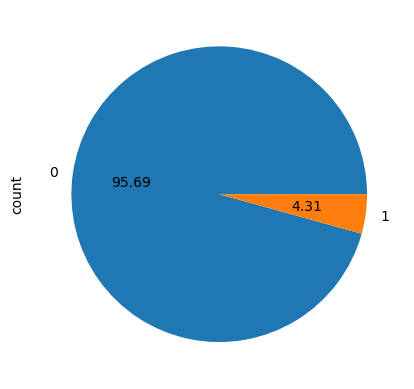

In [253]:
y.value_counts().plot.pie(autopct='%.2f')

# Oversampling to training data

# Data-splitting here

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
X_train.shape,X_test.shape

((49934, 10), (12484, 10))

In [256]:
#oversampling 
sm = RandomOverSampler(sampling_strategy = 'not majority')
X_res, y_res = sm.fit_resample(X_train, y_train)

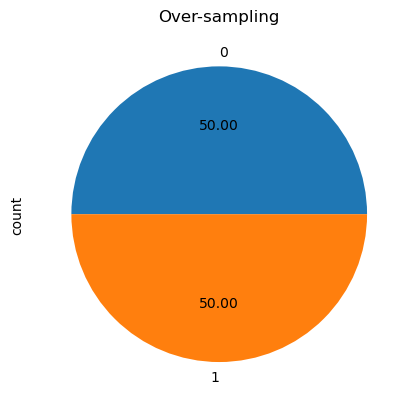

In [257]:
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [258]:
X_res.shape, y_res.shape

((95576, 10), (95576,))

In [259]:
X = copy.deepcopy(X_res)
y = copy.deepcopy(y_res)

In [260]:
X.shape,y.shape

((95576, 10), (95576,))

# corr plot

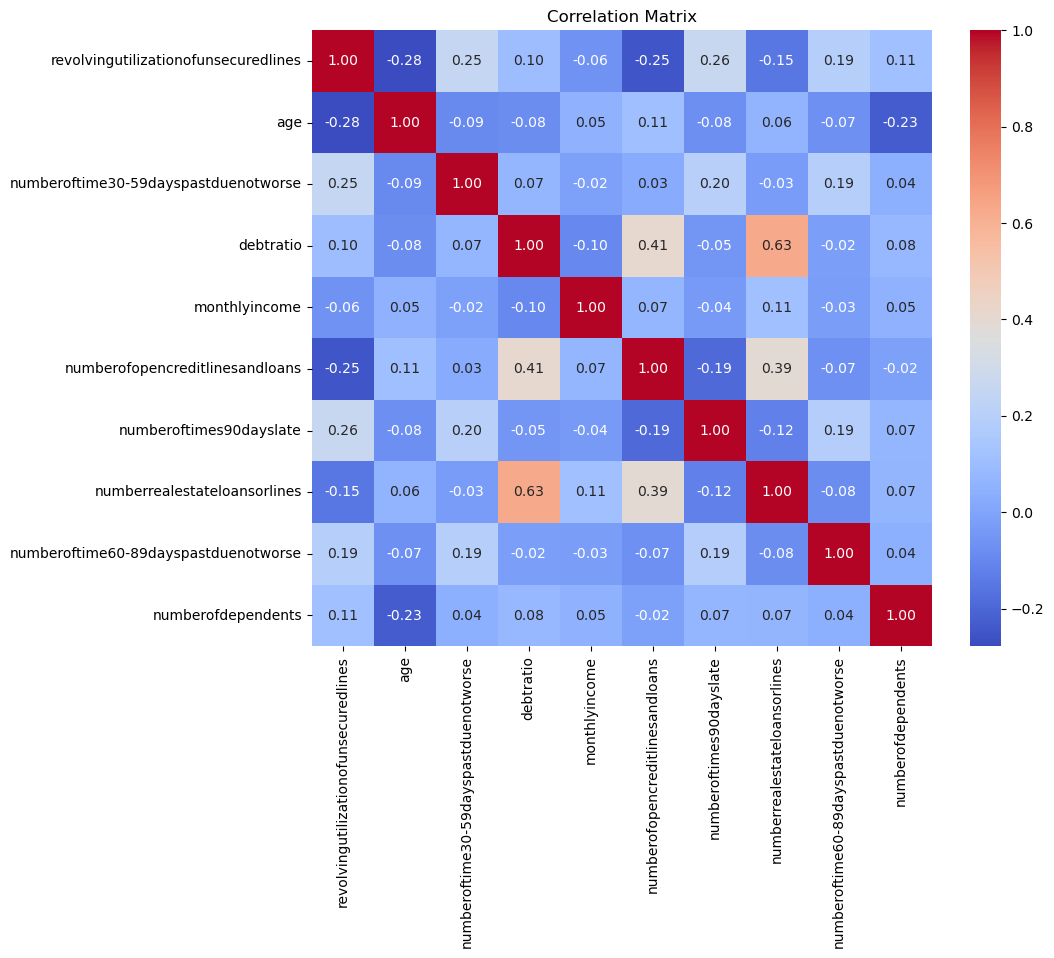

In [261]:
#multicolinearity
# Compute the correlation matrix
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

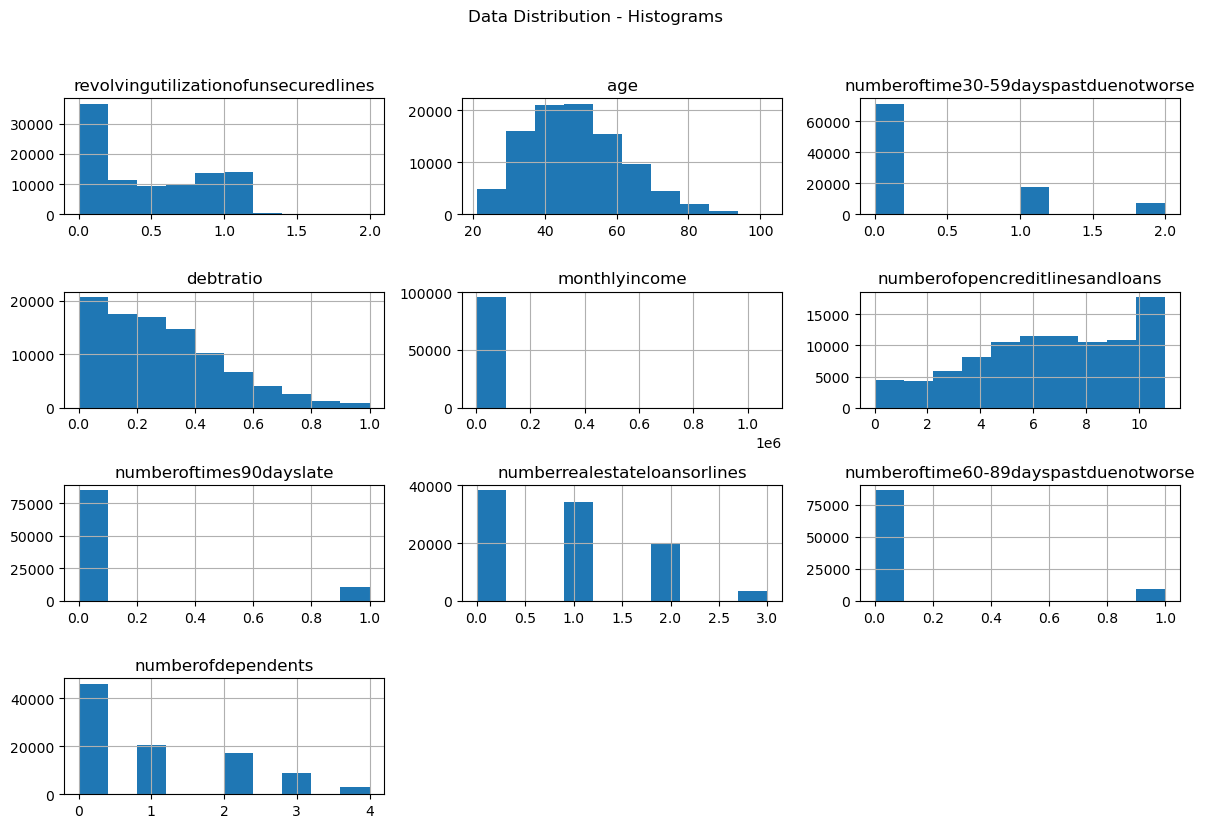

In [262]:
#examine the distrubtion of each column
#to determine whether we need to perform data binning
X.hist(figsize=(12, 8))
plt.suptitle("Data Distribution - Histograms", y=1.03)  # Add a title above the plots
plt.tight_layout()  # Adjust spacing between plots
plt.show()

In [131]:
#pd.qcut(X['revolvingutilizationofunsecuredlines'], q= 5,retbins = True)

(0          (0.0501, 0.262]
 1            (0.262, 0.65]
 2            (0.65, 0.982]
 3            (0.262, 0.65]
 4         (0.982, 50708.0]
                 ...       
 179107       (0.65, 0.982]
 179108    (0.982, 50708.0]
 179109       (0.262, 0.65]
 179110    (0.982, 50708.0]
 179111    (0.982, 50708.0]
 Name: revolvingutilizationofunsecuredlines, Length: 179112, dtype: category
 Categories (5, interval[float64, right]): [(-0.001, 0.0501] < (0.0501, 0.262] < (0.262, 0.65] < (0.65, 0.982] < (0.982, 50708.0]],
 array([0.00000000e+00, 5.00933940e-02, 2.62446124e-01, 6.49713362e-01,
        9.82003599e-01, 5.07080000e+04]))

In [135]:
#bin_edges = [0, 0.0501, 0.262, 0.65, 0.982,1]
#binned_revolvingutilizationofunsecuredlines = pd.cut(X['revolvingutilizationofunsecuredlines'], bins=bin_edges, right=False)

In [263]:
from optbinning import OptimalBinning
from optbinning import Scorecard, BinningProcess

list_features = X.columns.values
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

binning_process = BinningProcess(
    variable_names=list_features,
    selection_criteria=selection_criteria,
)

# Fit and transform dataset
df_train_binned = binning_process.fit_transform(X.values, y)

In [264]:
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,revolvingutilizationofunsecuredlines,numerical,OPTIMAL,False,11,1.00588,0.116884,0.527379,0.155404
1,age,numerical,OPTIMAL,True,9,0.218741,0.026526,0.241888,0.590741
2,numberoftime30-59dayspastduenotworse,numerical,OPTIMAL,True,3,0.480505,0.056291,0.287578,0.489047
3,debtratio,numerical,OPTIMAL,True,6,0.071754,0.008857,0.123614,0.188654
4,monthlyincome,numerical,OPTIMAL,True,9,0.105023,0.012978,0.179061,0.404576
5,numberofopencreditlinesandloans,numerical,OPTIMAL,True,8,0.072748,0.008895,0.114205,0.067051
6,numberoftimes90dayslate,numerical,OPTIMAL,True,2,0.446656,0.047427,0.184272,0.266541
7,numberrealestateloansorlines,numerical,OPTIMAL,True,3,0.03952,0.00493,0.101782,0.133796
8,numberoftime60-89dayspastduenotworse,numerical,OPTIMAL,True,2,0.310427,0.033993,0.146438,0.222703
9,numberofdependents,numerical,OPTIMAL,True,4,0.031884,0.003977,0.095675,0.107107


Jensen-Shannon Divergence (JS):

JS measures the similarity between two probability distributions, such as the original data distribution and the binned data distribution.
The JS value ranges from 0 to 1. A value closer to 0 indicates that the two distributions are very similar (good), while a value closer to 1 indicates that the two distributions are dissimilar (poor).
In the context of binning, a smaller JS value is generally considered better because it suggests that the binned distribution is closer to the original distribution

Gini Coefficient:

The Gini coefficient measures the inequality of a distribution and is often used in economics and income distribution analysis.
For the Gini coefficient, a value of 0 indicates perfect equality (everyone has the same value), while a value of 1 indicates perfect inequality (one person has all the value).
In the context of binning, a smaller Gini coefficient is generally considered better because it implies that the binned distribution is more balanced or equally distributed. In other words, the bins have similar sizes or frequencies.

In [265]:
#len(df_train_binned[0])#selected number of features
selected_optbin = binning_process.summary().loc[binning_process.summary()['selected'] == True, 'name'].tolist()
selected_optbin

['age',
 'numberoftime30-59dayspastduenotworse',
 'debtratio',
 'monthlyincome',
 'numberofopencreditlinesandloans',
 'numberoftimes90dayslate',
 'numberrealestateloansorlines',
 'numberoftime60-89dayspastduenotworse',
 'numberofdependents']

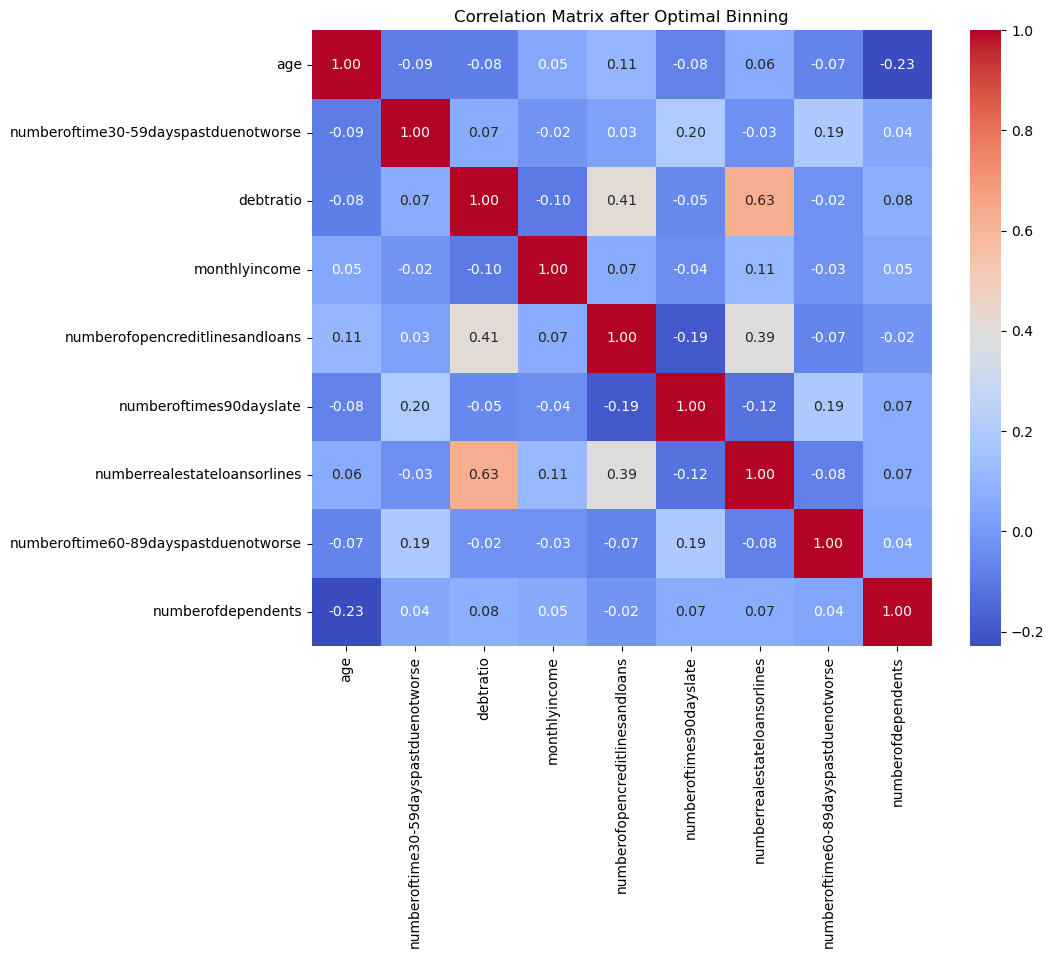

In [266]:
correlation_matrix_optbin = X[selected_optbin].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_optbin, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix after Optimal Binning")
plt.show()

# lasso feature selection techniques to deal with multicolinearity

In [59]:
#lasso feature selectionn
from sklearn.linear_model import LassoCV

# Create a LASSO model with cross-validation to select the regularization parameter (alpha)
lasso = LassoCV(cv=8)
lasso.fit(X, y)

# Get the selected features (coefficients that are not zero)
selected_features = X_res.columns[lasso.coef_ != 0]
print(selected_features)
X_selected_lasso = X[selected_features]

Index(['revolvingutilizationofunsecuredlines', 'age',
       'numberoftime30-59dayspastduenotworse', 'debtratio', 'monthlyincome'],
      dtype='object')


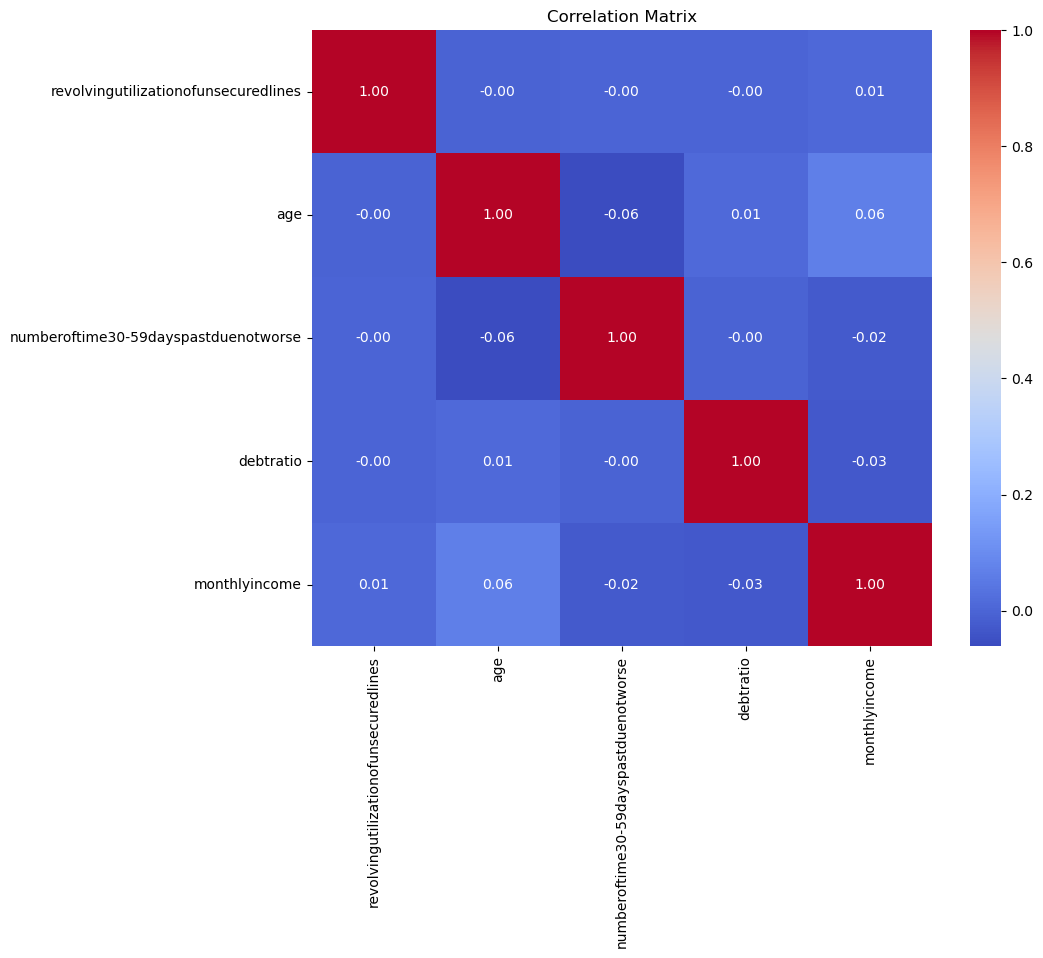

In [60]:
correlation_matrix_lasso = X_selected_lasso.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_lasso, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# continue with optbin selected features

In [268]:
#continue with optbin selected features
X_select= X[selected_optbin] 

In [ ]:
X_select.shape,y.shape #X_select 是X_train, X_test_select是X_test
X_test_select= X_test[selected_optbin] 
X_test_select.shape,y_test.shape

# Standardize data can help learning
scaler = StandardScaler()
x_train = scaler.fit_transform(X_select)
x_test = scaler.transform(X_test_select)#x-train, x-test, y, y-test

# Simple Logistic

In [314]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000], 'penalty': ['l2']}
lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring='roc_auc')
C = []

grid_search.fit(x_train, y)
C.append(grid_search.best_params_['C'])
print("Best hyperparameters: ", grid_search.best_params_)
print("Best roc-auc score on test set: ", grid_search.best_score_)
best_logit_C = grid_search.best_params_['C']
best_logit_pen = grid_search.best_params_['penalty']

Best hyperparameters:  {'C': 100, 'penalty': 'l2'}
Best roc-auc score on test set:  0.7864006183449231


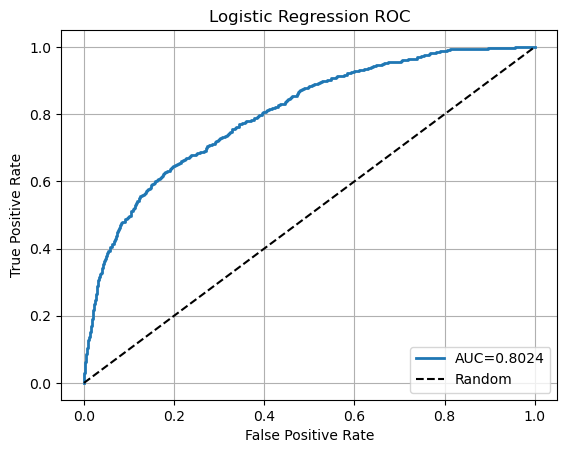

In [313]:
# Train the model
lr = LogisticRegression(C=grid_search.best_params_['C'], penalty=best_logit_pen, max_iter=1000)
lr.fit(x_train, y)

# ROC
y_probs = lr.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_true = y_test,  y_score = y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)

plt.plot(fpr,tpr, linewidth = 2, label = "AUC=%0.4f" %auc)
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.grid()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Logistic Regression ROC")
plt.legend(loc=4)
plt.show()

In [280]:
#Got the same result as below:
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(x_train, y)

# Predict the probabilities of delinquency for the test data
y_pred_proba = logreg.predict_proba(x_test)[:, 1]

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC score:', roc_auc)

ROC-AUC score: 0.8023832843316844


# Random Forest

In [282]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42) 
classifier.fit(x_train, y)
y_pred = classifier.predict(x_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC score:', roc_auc)

ROC-AUC score: 0.5427187293077728


In [316]:
#fine-tune
classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],    # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}


grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(x_train, y)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(x_test)

# Calculate the ROC-AUC score on the test set
roc_auc = roc_auc_score(y_test, y_pred)
print('Best ROC-AUC score:', grid_search.best_score_)
print('ROC-AUC score on test set:', roc_auc)

KeyboardInterrupt: 

# XGBoost

In [284]:
model = xgb.XGBClassifier()  
model.fit(x_train, y)
y_pred_prob = model.predict_proba(x_test)[:, 1]  
auc_roc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7550686176502897


In [317]:
#fine tune
model = xgb.XGBClassifier()


param_grid = {
    'n_estimators': [100, 200, 300],       # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],     # Learning rate (step size shrinkage)
    'max_depth': [3, 5, 7],                # Maximum depth of the trees
    'subsample': [0.8, 1.0],               # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0]         # Subsample ratio of columns when constructing each tree
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(x_train, y)

# Get the best model with tuned hyperparameters
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_prob = best_model.predict_proba(x_test)[:, 1]

# Calculate the AUC-ROC score on the test set
auc_roc = roc_auc_score(y_test, y_pred_prob)
print("Best AUC-ROC Score:", grid_search.best_score_)
print("AUC-ROC Score on test set:", auc_roc)

KeyboardInterrupt: 

# DNN

In [288]:
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
#scaler = StandardScaler()
lr = LogisticRegression()
model_lr = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])
model_lr.fit(x_train, y)
prob_lr = model_lr.predict(x_test)

2023-07-24 22:53:33.288609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [291]:
# Build the neural network
model = Sequential()
model.add(Dense(120, input_shape=(9,), activation='tanh')) # Hidden 1
model.add(Dropout(0.5))
model.add(Dense(60, activation='tanh')) # Hidden 2
model.add(Dropout(0.5))
model.add(Dense(30, activation='tanh')) # Hidden 3
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='Adam')

In [292]:
model.fit(x_train, y, epochs=10, batch_size=100)

Epoch 1/10
956/956 [==============================] - 2s 1ms/step - loss: 0.5875
Epoch 2/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5668
Epoch 3/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5634
Epoch 4/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5613
Epoch 5/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5590
Epoch 6/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5575
Epoch 7/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5567
Epoch 8/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5557
Epoch 9/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5546
Epoch 10/10
956/956 [==============================] - 1s 1ms/step - loss: 0.5541


In [293]:
prob_keras = model.predict(x_test)

391/391 [==============================] - 0s 689us/step


In [294]:
roc_auc_score(y_test, prob_keras)

0.8048303751310956

In [148]:
'''
# Define the number of bins
num_bins = 10

data_binned = pd.DataFrame()

# Bin the data
for feature in features:
    data_binned[feature] = pd.qcut(data_no_outliers[feature], q=num_bins, duplicates='drop')
# Add the target variable to the binned data
data_binned[target] = dff[target]

# Display the first few rows of the dataframe
data_binned

'''

"\n# Define the number of bins\nnum_bins = 10\n\ndata_binned = pd.DataFrame()\n\n# Bin the data\nfor feature in features:\n    data_binned[feature] = pd.qcut(data_no_outliers[feature], q=num_bins, duplicates='drop')\n# Add the target variable to the binned data\ndata_binned[target] = dff[target]\n\n# Display the first few rows of the dataframe\ndata_binned\n\n"

In [149]:
'''
# Count the number of elements in each bin for each feature
bin_counts = data_binned[features].apply(pd.Series.value_counts).transpose()

# Display the bin counts
bin_counts

'''

'\n# Count the number of elements in each bin for each feature\nbin_counts = data_binned[features].apply(pd.Series.value_counts).transpose()\n\n# Display the bin counts\nbin_counts\n\n'

# Optimal binning + Socrecard

http://gnpalencia.org/optbinning/binning_process.html

In [298]:
from sklearn.linear_model import LogisticRegression 
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

In [299]:
%%time
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 1000}
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True,
)

scorecard.fit(X,y)

CPU times: user 1.35 s, sys: 129 ms, total: 1.48 s
Wall time: 1.2 s


Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 0.5,
                                                                    'min': 0.005,
                                                                    'strategy': 'highest'}},
                                         variable_names=array(['revolvingutilizationofunsecuredlines', 'age',
       'numberoftime30-59dayspastduenotworse', 'debtratio',
       'monthlyincome', 'numberofopencreditlinesandloans',
       'numberoftimes90dayslate', 'numberrealestateloansorlines',
       'numberoftime60-89dayspastduenotworse', 'numberofdependents'],
      dtype=object)),
          estimator=LogisticRegression(C=3, max_iter=1000, random_state=161),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0})

In [300]:
scorecard_summary = scorecard.table(style="detailed").round(3)
#scorecard_summary.to_csv('scorecard_table_detailed.csv', index=False)
#scorecard_summary

# Group by 'IV' and calculate the sum of 'IV' for each variable
scorecard_sum = scorecard_summary.groupby('Variable')['IV'].sum().sort_values(ascending=False)
scorecard_sum

Variable
numberoftime30-59dayspastduenotworse    0.481
numberoftimes90dayslate                 0.446
numberoftime60-89dayspastduenotworse    0.311
age                                     0.220
monthlyincome                           0.106
numberofopencreditlinesandloans         0.072
debtratio                               0.072
numberrealestateloansorlines            0.039
numberofdependents                      0.032
Name: IV, dtype: float64

In [301]:
# Visualizing Scorecard performance
from optbinning.scorecard.plots import plot_ks, plot_auc_roc
from sklearn.metrics import roc_auc_score

In [302]:
y_pred_proba = scorecard.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC score:', roc_auc)

ROC-AUC score: 0.8040269260532286


In [172]:
#plot_auc_roc(y_test, y_pred_proba)

# Fine-tune hyperparameters

In [303]:
# Import the necessary libraries
from sklearn.model_selection import GridSearchCV

Logic behind grid search:
- penalty is a regularization term added to the loss function that shrinks model parameters to prevent overfitting. The possible values are 'l1', 'l2', 'elasticnet', and 'none'.

- C is the inverse of regularization strength. Smaller values specify stronger regularization. The possible values are 0.001, 0.01, 0.1, 1, 10, 100, and 1000.

- solver is the algorithm to use in the optimization problem. The possible values are 'newton-cg', 'lbfgs', 'liblinear', 'sag', and 'saga'.

logistic regression model for each combination of penalty, C, and solver.

Each model is evaluated using 5-fold cross-validation, which means the data is split into 5 subsets, the model is trained on 4 subsets and tested on the remaining subset, and this process is repeated 5 times so that each subset is used for testing once.

The performance metric is ROC-AUC score, which measures the ability of the model to distinguish between the positive and negative classes.

The combination of hyperparameters that gives the highest ROC-AUC score is selected as the best parameters.

In [304]:
# Initialize the logistic regression model with a larger maximum number of iterations
logreg = LogisticRegression(max_iter=1000)

# Define the parameter distribution with a larger range of tolerances
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 10, 20),
    'solver': ['liblinear', 'saga'],
    'tol': np.logspace(-4, 0, 20)  # Increase the upper bound to 10^0 = 1
}


# Initialize the grid search
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print('Best parameters:', best_params)

# Get the best score
best_score = grid_search.best_score_

# Print the best score
print('Best score:', best_score)

NameError: name 'param_grid' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the logistic regression model with a larger maximum number of iterations
logreg = LogisticRegression(max_iter=1000)

# Define the parameter distribution with a larger range of tolerances
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 10, 20),
    'solver': ['liblinear', 'saga'],
    'tol': np.logspace(-4, 0, 20)  # Increase the upper bound to 10^0 = 1
}

# Initialize the randomized search
random_search = RandomizedSearchCV(logreg, param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Print the best parameters
print('Best parameters:', best_params)

# Get the best score
best_score = random_search.best_score_

# Print the best score
print('Best score:', best_score)

# Prediction & Score Calculation

In [ ]:
# Define the range of the credit scores
min_score = 300
max_score = 850

# Convert the probabilities into odds
odds = y_pred_proba / (1 - y_pred_proba)

# Perform a logistic transformation on the odds
log_odds = np.log(odds)

# Scale the log odds to the range of the credit scores
credit_scores = (log_odds - np.min(log_odds)) / (np.max(log_odds) - np.min(log_odds)) * (max_score - min_score) + min_score

# Round the credit scores to integers
credit_scores = np.round(credit_scores)

# Display the first 10 credit scores
print((credit_scores))
len(credit_scores)

- Convert the probabilities into odds: The odds of an event is the probability of the event happening divided by the probability of the event not happening. In this case, the event is delinquency. So odds = y_pred_proba / (1 - y_pred_proba) calculates the odds of delinquency for each individual.

- Perform a logistic transformation on the odds: The logistic transformation is the natural logarithm of the odds. It transforms the odds, which range from 0 to infinity, to log odds, which range from negative infinity to positive infinity. So log_odds = np.log(odds) calculates the log odds of delinquency for each individual.

- Scale the log odds to the range of the credit scores: This step transforms the log odds, which range from negative infinity to positive infinity, to credit scores, which range from min_score to max_score. The formula (log_odds - np.min(log_odds)) / (np.max(log_odds) - np.min(log_odds)) * (max_score - min_score) + min_score is a min-max normalization, which scales the log odds to the range of the credit scores.

- Round the credit scores to integers

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the credit scores
df_scores = pd.DataFrame(credit_scores, columns=['Credit Score'])

# Create a heatmap of the credit scores
plt.figure(figsize=(12, 8))
sns.heatmap(df_scores, cmap='coolwarm', annot=True, fmt='.0f')
plt.title('Heatmap of Credit Scores')
plt.show()

In [ ]:
#test model function